In [33]:
import os
import pandas as pd
import datetime

In [53]:
csv_list = []
appended = pd.DataFrame()
LUIGI_LOG_PATH='/usr/local/trustyou/home/andream/nfs/processmining/'
#LUIGI_LOG_PATH = '/usr/local/trustyou/home/andream/nfs/processmining/minilogs/daily/'
#LUIGI_LOG_PATH = '/usr/local/trustyou/home/andream/nfs/processmining/minilogs/table-precomp/logs/tch/'
for filename in os.listdir(LUIGI_LOG_PATH):
    if filename.endswith('.csv') and filename.startswith('catts_semicolon-running-example-just-two-cases.csv'):
    #if filename.endswith('.csv') and filename.startswith('catts_daily.2019-09-.csv'):
        log_path = LUIGI_LOG_PATH+'/'+filename
        csv_list.append(filename)
        print('Preprocessing... ',log_path)
        df = pd.read_csv(log_path, index_col=False)
        appended = appended.append(df)

#appended_df
csv_list.sort()
print(csv_list)

#appended_df.to_datetime(start_time, format="%Y-%m-%d:%H:%M:%S").sort_values()
appended['start_time'] = pd.to_datetime(appended['start_time'], format="%Y-%m-%d %H:%M:%S").sort_values()
appended['end_time'] = pd.to_datetime(appended['end_time'], format="%Y-%m-%d %H:%M:%S").sort_values()
appended = appended.sort_values(by=['start_time'], ascending=True)
appended['case'] = appended.apply(lambda row: str(row['case']), axis=1)
appended

Preprocessing...  /usr/local/trustyou/home/andream/nfs/processmining//catts_semicolon-running-example-just-two-cases.csv
['catts_semicolon-running-example-just-two-cases.csv']


,case,activity,start_time,end_time
1,1,examine thoroughly,2010-12-30 10:06:00,2010-12-31 10:06:00
0,1,register request,2010-12-30 11:02:00,2010-12-30 11:20:00
2,1,check ticket,2011-01-05 15:12:00,2011-01-06 15:12:00
3,1,decide,2011-01-06 11:18:00,2011-01-07 14:24:00
5,4,register request,2011-01-06 15:02:00,2011-01-06 15:20:00
6,4,check ticket,2011-01-07 12:06:00,2011-01-08 12:06:00
4,1,reject request,2011-01-07 14:14:00,2011-01-07 14:24:00
7,4,examine thoroughly,2011-01-07 14:43:00,2011-01-08 14:06:00
8,4,decide,2011-01-10 12:02:00,2011-01-12 15:44:00
9,4,reject request,2011-01-12 15:34:00,2011-01-12 15:44:00


In [54]:
def get_zero_points(group):
    group['zero_point'] = group['start_time'].min()
    return group

In [55]:
print(appended['start_time'].min(), appended['end_time'].max())
grouped = appended.groupby(['case'])
grouped = grouped.apply(get_zero_points)
grouped.head()

2010-12-30 10:06:00 2011-01-12 15:44:00


,case,activity,start_time,end_time,zero_point
1,1,examine thoroughly,2010-12-30 10:06:00,2010-12-31 10:06:00,2010-12-30 10:06:00
0,1,register request,2010-12-30 11:02:00,2010-12-30 11:20:00,2010-12-30 10:06:00
2,1,check ticket,2011-01-05 15:12:00,2011-01-06 15:12:00,2010-12-30 10:06:00
3,1,decide,2011-01-06 11:18:00,2011-01-07 14:24:00,2010-12-30 10:06:00
5,4,register request,2011-01-06 15:02:00,2011-01-06 15:20:00,2011-01-06 15:02:00


In [56]:
def get_duration(start_time, end_time):
    start = datetime.datetime.strptime(start_time, '%Y-%m-%d %H:%M:%S')
    end = datetime.datetime.strptime(end_time, '%Y-%m-%d %H:%M:%S')
    duration = abs(end - start)
    return duration
#get_duration(ex['timestamp'][10],ex['timestamp'][1])

In [57]:
#zero_points = appended[appended['activity']=='AllTasks']
#zero_points['zero_point'] = zero_points['start_time']
#zero_points = zero_points.drop(['activity', 'start_time', 'end_time'], axis=1)
#zero_points.head()

In [58]:
#tt = pd.merge(start_df, end_df, on=['task_call', 'source_file'], how='outer')

appended = pd.merge(grouped, appended, on = ['case', 'activity', 'start_time', 'end_time'], how = 'inner') 
print(len(appended))
appended.head()

10


,case,activity,start_time,end_time,zero_point
0,1,examine thoroughly,2010-12-30 10:06:00,2010-12-31 10:06:00,2010-12-30 10:06:00
1,1,register request,2010-12-30 11:02:00,2010-12-30 11:20:00,2010-12-30 10:06:00
2,1,check ticket,2011-01-05 15:12:00,2011-01-06 15:12:00,2010-12-30 10:06:00
3,1,decide,2011-01-06 11:18:00,2011-01-07 14:24:00,2010-12-30 10:06:00
4,4,register request,2011-01-06 15:02:00,2011-01-06 15:20:00,2011-01-06 15:02:00


In [59]:
#excluding = ['AllTasks', 'CrawlTask', 'ExtractTask']
excluding = ['AllTasks']
exclusive = appended.copy()
exclusive['rel_start'] = exclusive.apply(lambda row: 
                                       str(get_duration(str(row['zero_point']),
                                                        str(row['start_time']))), axis=1)
exclusive['rel_end'] = exclusive.apply(lambda row: 
                                       str(get_duration(str(row['zero_point']),
                                                        str(row['end_time']))), axis=1)
#list(pd.to_timedelta(x, errors="coerce").dt.total_seconds())

exclusive['num_start']= list(pd.to_timedelta(exclusive['rel_start'], errors="coerce").dt.total_seconds ())
exclusive['num_end']= list(pd.to_timedelta(exclusive['rel_end'], errors="coerce").dt.total_seconds ())

#appended.apply(lambda row: row['rel_start'], axis=1)
#appended['num_end']= appended.apply(lambda row: (row['rel_end'].total_seconds())/60/60, axis=1)

exclusive = exclusive[['case', 'activity','rel_start', 'rel_end', 'num_start', 'num_end', 'start_time', 'end_time']]

exclusive = exclusive.sort_values(by=['num_start'], ascending=True)
exclusive = exclusive[~exclusive['activity'].isin(excluding)].reset_index()
#exclusive = exclusive.head(100)
print(len(exclusive))
exclusive

10


,index,case,activity,rel_start,rel_end,num_start,num_end,start_time,end_time
0,0,1,examine thoroughly,0:00:00,"1 day, 0:00:00",0.0,86400.0,2010-12-30 10:06:00,2010-12-31 10:06:00
1,4,4,register request,0:00:00,0:18:00,0.0,1080.0,2011-01-06 15:02:00,2011-01-06 15:20:00
2,1,1,register request,0:56:00,1:14:00,3360.0,4440.0,2010-12-30 11:02:00,2010-12-30 11:20:00
3,5,4,check ticket,21:04:00,"1 day, 21:04:00",75840.0,162240.0,2011-01-07 12:06:00,2011-01-08 12:06:00
4,7,4,examine thoroughly,23:41:00,"1 day, 23:04:00",85260.0,169440.0,2011-01-07 14:43:00,2011-01-08 14:06:00
5,8,4,decide,"3 days, 21:00:00","6 days, 0:42:00",334800.0,520920.0,2011-01-10 12:02:00,2011-01-12 15:44:00
6,9,4,reject request,"6 days, 0:32:00","6 days, 0:42:00",520320.0,520920.0,2011-01-12 15:34:00,2011-01-12 15:44:00
7,2,1,check ticket,"6 days, 5:06:00","7 days, 5:06:00",536760.0,623160.0,2011-01-05 15:12:00,2011-01-06 15:12:00
8,3,1,decide,"7 days, 1:12:00","8 days, 4:18:00",609120.0,706680.0,2011-01-06 11:18:00,2011-01-07 14:24:00
9,6,1,reject request,"8 days, 4:08:00","8 days, 4:18:00",706080.0,706680.0,2011-01-07 14:14:00,2011-01-07 14:24:00


# Point Transformer: Start time - End time

In [60]:
snippet = exclusive[['case','activity','rel_start','rel_end','num_start','num_end']].iloc[: , :]
#snippet = exclusive.iloc[199:500 , :].reset_index()
snippet = snippet.sort_values(by=['case','num_start'], ascending=True)
print(len(snippet))

10


In [61]:
counts = snippet.groupby(['activity']).size().reset_index(name='counts').sort_values(by=['counts'], ascending=False)
counts = counts.sort_values(by=['counts'], ascending = False)
counts.head()

#appended = appended.head(100)
#len(appended)
unique_act = snippet['activity'].unique().tolist()
print(len(unique_act), ' activities')

unique_trace = snippet['case'].unique().tolist()
print(len(unique_trace), ' cases')


5  activities
2  cases


In [62]:
def get_time_list_from_seconds(list):
    result = []
    for item in list:
        if item < 0: 
            result.append('')
        else: 
            result.append(datetime.timedelta(seconds=item))
    return result

def get_color_from_label(label, color):
    return color

import matplotlib.pyplot as plt
import matplotlib.lines as mlines

def newline(p1, p2):
    ax = plt.gca()
    xmin, xmax = ax.get_xbound()

    if(p2[0] == p1[0]):
        xmin = xmax = p1[0]
        ymin, ymax = ax.get_ybound()
    else:
        ymax = p1[1]+(p2[1]-p1[1])/(p2[0]-p1[0])*(xmax-p1[0])
        ymin = p1[1]+(p2[1]-p1[1])/(p2[0]-p1[0])*(xmin-p1[0])

    l = mlines.Line2D([xmin,xmax], [ymin,ymax], color='grey', linestyle='--', linewidth=1)
    ax.add_line(l)
    return l

In [63]:
import time

def avg_datetime(series):
    averages = (series.sum())/len(series)
    #averages = time.strftime('%H:%M:%S', time.gmtime(averages))
    return averages

def get_average_times(group):
    group['average_start'] = time.strftime('%H:%M:%S', time.gmtime(avg_datetime(group['num_start'])))
    group['average_end'] = time.strftime('%H:%M:%S', time.gmtime(avg_datetime(group['num_end'])))
    group['num_start'] = avg_datetime(group['num_start'])
    group['num_end'] = avg_datetime(group['num_end'])
    return group

def get_data_selection_avgtrace(df):
    average_trace = df[['case','activity','rel_start','rel_end','num_start','num_end']].iloc[: , :]
    average_trace = average_trace.groupby(['activity'])
    average_trace = average_trace.apply(get_average_times)
    average_trace = average_trace.drop_duplicates('activity', keep='first').reset_index()
    average_trace['case'] = 'Average Case'
    average_trace = average_trace[['activity','average_start', 'average_end','num_start','num_end', 'case']].sort_values(by=['num_start'])
    return average_trace

In [64]:
def get_skyline_points(df):
    #skyline = pd.DataFrame(columns=['x','y'])
    df.sort_values(by=['num_start'])
    max_x = []
    max_y = []
    for i, e in enumerate(df['num_start']):
        maxi = max(df['num_start'][0:i+1].values.tolist())
        mayi = max(df['num_end'][0:i+1].values.tolist())
        if maxi in df[df['num_end']==mayi]['num_start'].values:
            max_x.append(maxi)
            max_y.append(mayi)

    skyline = pd.DataFrame({'num_start':max_x, 'num_end':max_y})
    skyline = skyline.drop_duplicates().reset_index()[['num_start','num_end']]

    return skyline

#first_case = snippet.loc[snippet['case']==snippet['case'][0]].reset_index()
#get_skyline_points(first_case).head()

In [69]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import numpy as np
import pandas as pd
import sys

def plot_point_transformer(title, df, flavor=None, activity=None, traces=None,  allen_point=None, size=None, duration_plot=None, draw_skylines=None, draw_traces=None):
    fig, ax = plt.subplots()
    if size: 
        fig.set_size_inches(18.5, 18.5)

    #colormap = cm.nipy_spectral
    #colormap = cm.gist_ncar
    #colormap = cm.prism
    #colormap = cm.tab20
    colormap = cm.hsv
    colorlist = [colors.rgb2hex(colormap(i)) for i in np.linspace(0, 0.9, len(unique_act))]
    legend = dict(zip(unique_act, colorlist))
    colorby = 'activity'
    
    if activity:
        data_selection = df.loc[df['activity']==activity].reset_index()
        colorby = 'case'
    elif traces:
        data_selection = df.loc[df['case'].isin(traces)].reset_index()
    elif flavor == 'avgtrace':
        data_selection = get_data_selection_avgtrace(df)
    elif flavor == 'all':
        data_selection = df
    
    try: 
        # Scatter plot points
        for i, e in enumerate(data_selection['num_start']):
            x = data_selection['num_start'][i]
            y = data_selection['num_end'][i]
            l = data_selection[colorby][i]
            c = legend.get(l)

            ax.scatter(x, y, label=l, s=50, linewidth=0.1, c=c)
    except UnboundLocalError:
        print(flavor," not known")
        return
    
    yin, yax= ax.get_ylim()
    xin, xax= ax.get_xlim()
    
    if not duration_plot: 
        #Draw diagonal
        linin= min(int(yin), int(xin))
        linax= max(int(yax), int(xax))
        line=np.linspace(linin,linax) 
        ax.plot(line,line,'k-', linestyle='--', linewidth=1, c='grey')
        ax.set_ylabel('End time [mins]')
    else: 
        ax.set_ylabel('Duration [seconds]')

    if traces:
        colormapt = cm.gist_ncar
        trace_colorlist = [colors.rgb2hex(colormapt(i)) for i in np.linspace(0, 0.9, len(unique_trace))]
        trace_legend = dict(zip(unique_trace, trace_colorlist))
        for j, k in enumerate(data_selection['case'].drop_duplicates()):
            current = data_selection[data_selection['case']==k]
            skyline = get_skyline_points(current)
            l = k
            c = trace_legend.get(l)

            if draw_skylines: 
                ax.plot(skyline['num_start'], skyline['num_end'], label='skyline '+k, zorder=0, color=c)
            else: 
                ax.plot(current['num_start'], current['num_end'], label='trace '+k, zorder=0, color=c)
            
    if not allen_point is None :
        
        if flavor == 'avgtrace':
            activity = allen_point['activity'].values[0]
            allen_point = data_selection[data_selection['activity']==activity]
            
        xmax = max(data_selection['num_start'].values)
        ymax = max(data_selection['num_end'].values)

        x = allen_point['num_start'].values[0]
        y = allen_point['num_end'].values[0]

        if not duration_plot:
            ax.plot([x,x],[x,yax],'k-', c='grey', linewidth=1, linestyle='--')
            ax.plot([y,y],[y,yax],'k-', c='grey', linewidth=1, linestyle='--')
            ax.plot([0,x],[x,x],'k-', c='grey', linewidth=1, linestyle='--')
            ax.plot([0,y],[y,y],'k-', c='grey', linewidth=1, linestyle='--')
        else: 
            ax.axvline(x, c='grey', linewidth=1, linestyle='--')
            ax.axvline(x+y, c='grey', linewidth=1, linestyle='--')
            newline([x+x,0],[x,y])
            newline([x,0],[0,y])
    
    
    ax.legend()
    ax.set_xlabel('Start time [mins]')

    xlocs, labels = plt.xticks()
    ylocs, labels = plt.yticks()
    plt.xticks(xlocs[1:], get_time_list_from_seconds(xlocs[1:]),rotation='vertical')
    plt.yticks(ylocs[1:], get_time_list_from_seconds(ylocs[1:])) 


    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys())
    plt.title(title)
    plt.show()
    #TODO: Drifts?
#plot_point_transformer('Point transformer: Activity \''+ str(snippet['activity'][6]) + '\' only', snippet , flavor='oneact', activity='reject request')
#plot_point_transformer('Point transformer: All activities in all traces', snippet, flavor='all')
#plot_point_transformer('Point transformer: Trace \''+ str(snippet['case'][0]) + '\' only', snippet, flavor='onetrace')
#plot_point_transformer('Point transformer: Average trace from all activities', snippet, flavor='avgtrace')

In [66]:
row = snippet.iloc[ 0 , : ].to_frame().transpose()
#row = snippet[(snippet['case']==1)&(snippet['num_start']==536760)]
print(row)
ymin=((row['num_end'].values[0]
      -row['num_start'].values[0]))
print(ymin)

print('Num. end ', row['num_end'].values[0])
print('Num. start ', row['num_start'].values[0])

  case            activity rel_start         rel_end num_start num_end
0    1  examine thoroughly   0:00:00  1 day, 0:00:00         0   86400
86400.0
Num. end  86400.0
Num. start  0.0


## Point transformer: One trace only

<class 'str'>


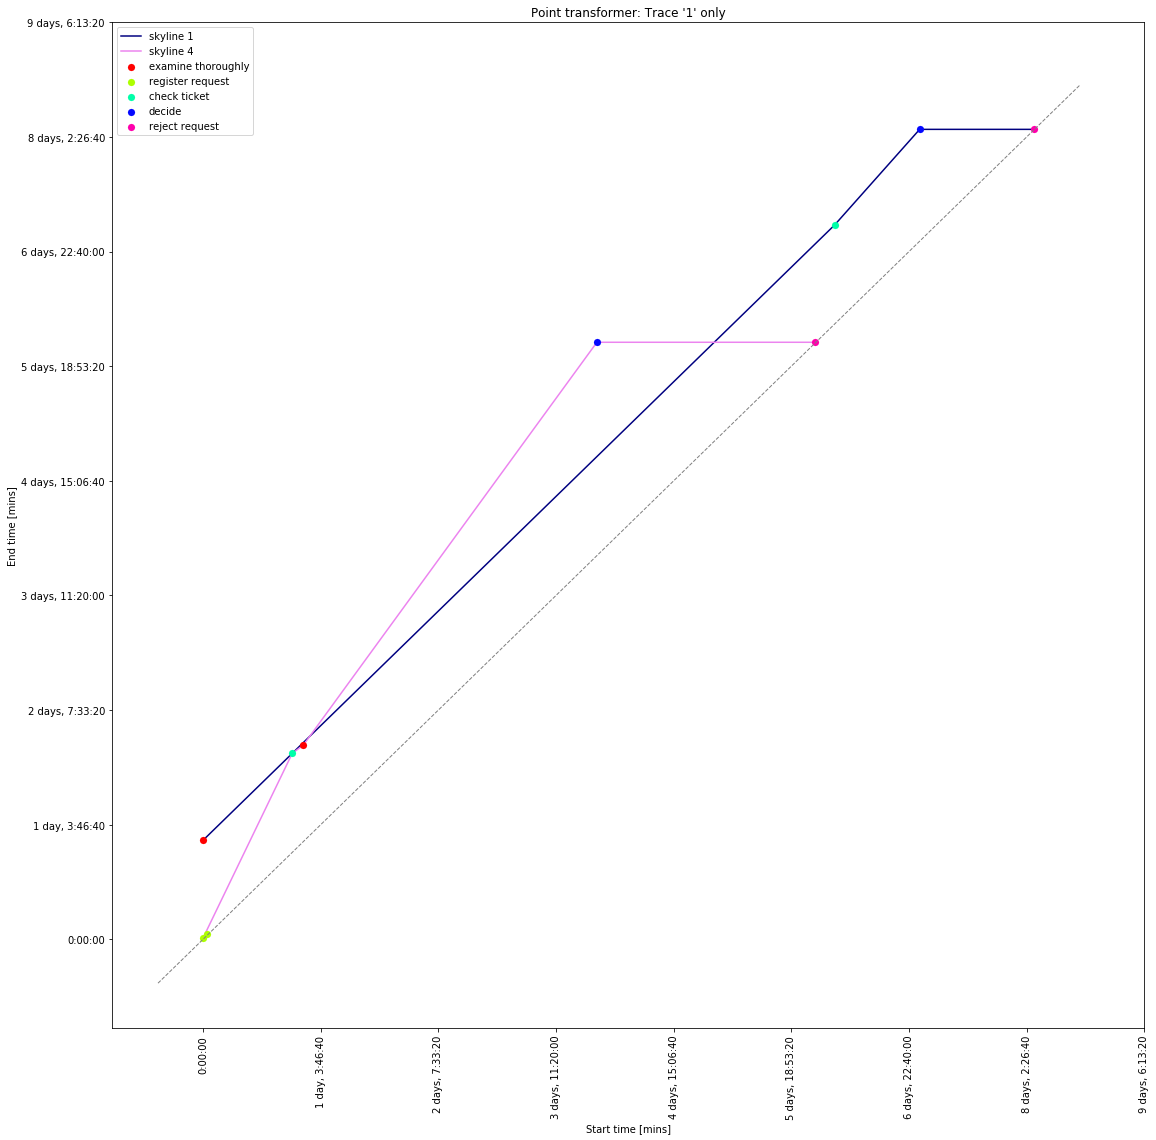

In [72]:
#plot_point_transformer('Point transformer: Trace \''+ str(snippet['case'][0]) + '\' only', snippet, flavor='onetrace', draw_traces=1)
traces_selection = snippet['case'].drop_duplicates().tolist()
print(type(snippet['case'][0]))
plot_point_transformer('Point transformer: Trace \''+ str(snippet['case'][0]) + '\' only', snippet, size=1, flavor='onetrace', traces=traces_selection, draw_skylines=1)


## Point Transformer: All activities in all traces

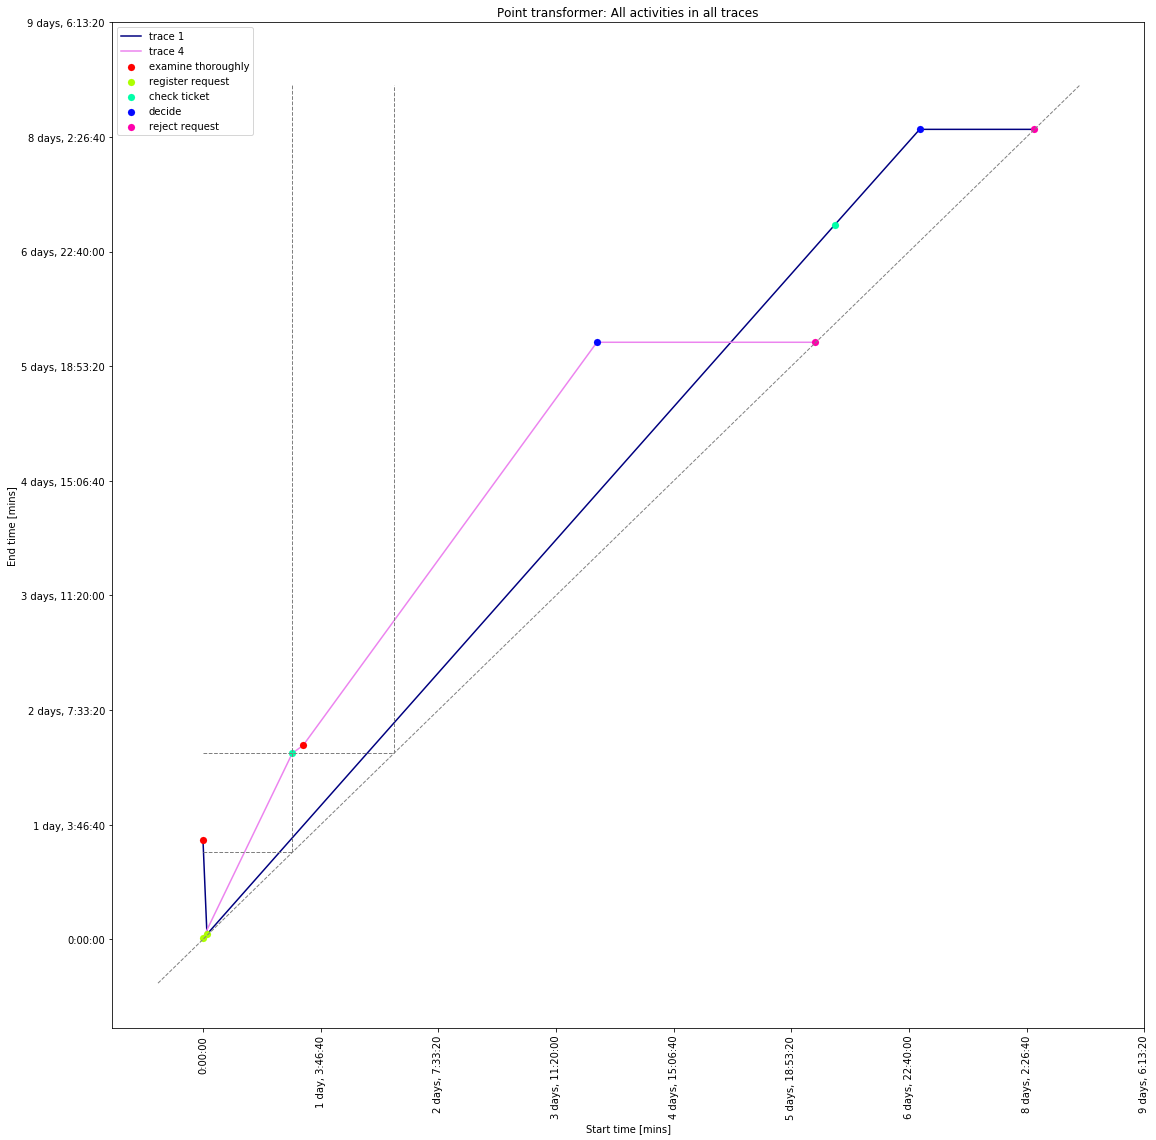

In [73]:
point = snippet.iloc[ 6 , : ].to_frame().transpose()
traces_selection = snippet['case'].drop_duplicates().tolist()
#print(point)
plot_point_transformer('Point transformer: All activities in all traces', snippet, flavor='all', allen_point=point, traces=traces_selection,  size=1)
#plot_point_transformer('Point transformer: All activities in all traces', snippet, flavor='all', size=1, allen_point=snippet[(snippet['case']==4)&(snippet['num_start']==75840)])

## Point transformer: Average trace from all activities

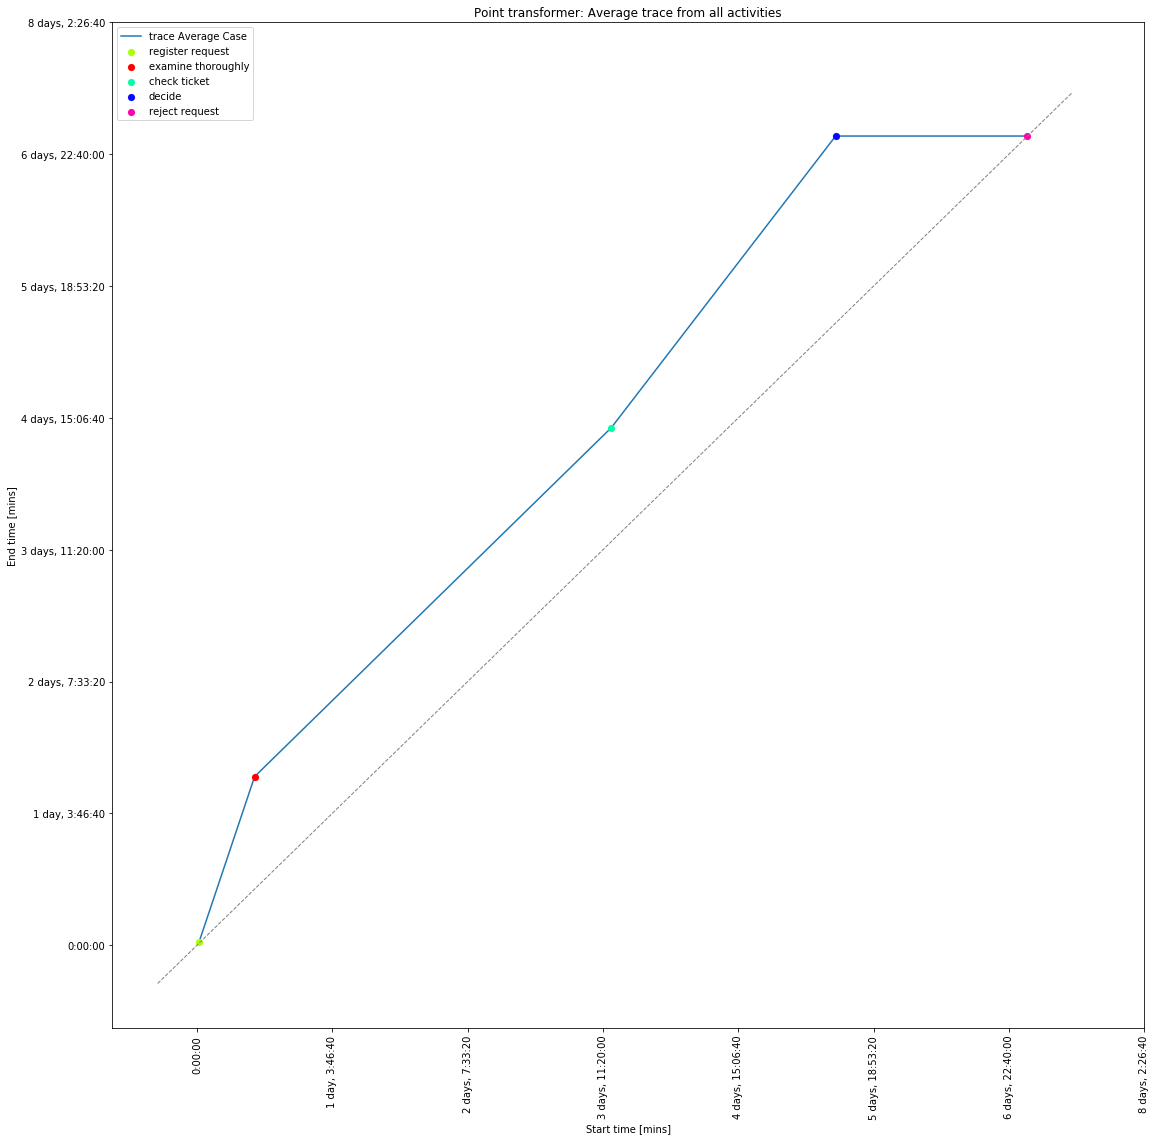

In [74]:
#TODO: Include avgtrace in traces as data 
data_selection = get_data_selection_avgtrace(snippet)
traces_selection = data_selection['case'].drop_duplicates().tolist()
plot_point_transformer('Point transformer: Average trace from all activities', data_selection, flavor='avgtrace', traces=traces_selection, size=1)
#plot_point_transformer('Point transformer: Average trace from all activities', snippet, flavor='avgtrace', allen_point=point, draw_traces=1)

## Point transformer: One Activity only

decide


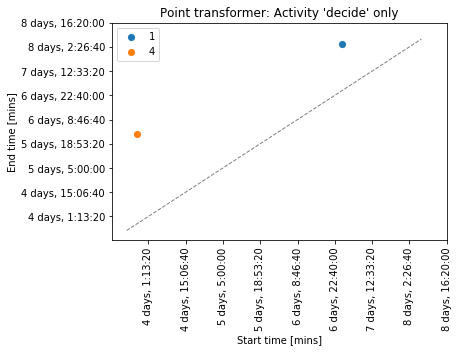

In [75]:
print(df['activity'][8])
plot_point_transformer('Point transformer: Activity \''+ str(snippet['activity'][8]) + '\' only', snippet , flavor='oneact', activity=df['activity'][8],draw_traces=1)

In [76]:
#TODO: Get rid of 'draw_traces' parameter
#TODO: Get rid of 'flavour' parameter
#TODO: Other diagram with duration and start time
#TODO: Select trace for one trace
#TODO: Clean real data from daily to parameterwise activities
#TODO: Pseudonimize data for uni
#TODO: Add multiple traces to legend in 'all' diagram
#TODO: Plot medium log (e.g. 100 traces)


#TODO: Try out different data: Log Generator anschauen (Jonas)
#    - Dummy dummy (1 linearen trace ohne overlapps)
#    - Dummy dummy (1-2 Traces ohne overlapps) Expectation and outlier (Erkennt man outlier (structure/allen struktur/time)?)
#    - ohne/mit Strukturänderung
#    - Plot medium log (e.g. 100 traces)


# Point Transformer: Start time - Duration

In [77]:
snippet['rel_end'].head()[0]

'1 day, 0:00:00'

In [78]:
def get_duration(start_time, end_time):
    start = datetime.datetime.strptime(start_time, '%Y-%m-%d %H:%M:%S')
    end = datetime.datetime.strptime(end_time, '%Y-%m-%d %H:%M:%S')
    duration = abs(end - start)
    return duration
#get_duration(ex['timestamp'][10],ex['timestamp'][1])

In [79]:
w_duration = exclusive.copy()
w_duration['duration'] = w_duration.apply(lambda row: str(get_duration(str(row['start_time']),str(row['end_time']))), axis=1)
w_duration['t_duration']= w_duration.apply(lambda row: (get_duration(str(row['start_time']),str(row['end_time'])).total_seconds()), axis=1)


w_duration = w_duration[['case','activity','rel_start','num_start', 'duration', 't_duration']]
w_duration['rel_end']=w_duration['duration']
w_duration['num_end']=w_duration['t_duration']

print(len(w_duration))
w_duration.head()

10


,case,activity,rel_start,num_start,duration,t_duration,rel_end,num_end
0,1,examine thoroughly,0:00:00,0.0,"1 day, 0:00:00",86400.0,"1 day, 0:00:00",86400.0
1,4,register request,0:00:00,0.0,0:18:00,1080.0,0:18:00,1080.0
2,1,register request,0:56:00,3360.0,0:18:00,1080.0,0:18:00,1080.0
3,4,check ticket,21:04:00,75840.0,"1 day, 0:00:00",86400.0,"1 day, 0:00:00",86400.0
4,4,examine thoroughly,23:41:00,85260.0,23:23:00,84180.0,23:23:00,84180.0


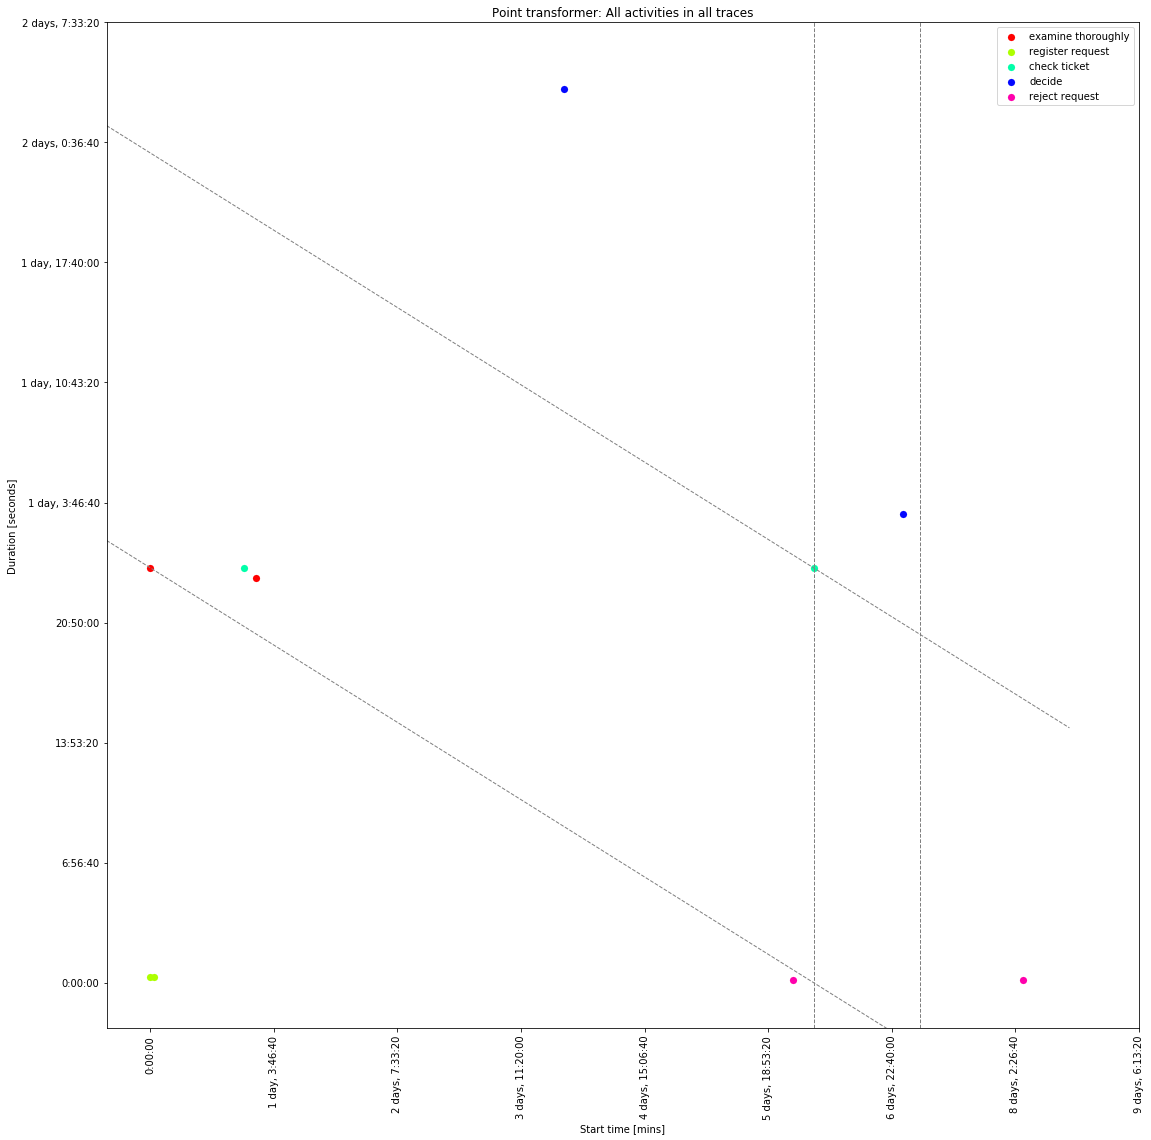

In [80]:
point = w_duration.iloc[ 7 , : ].to_frame().transpose()
#print(point)
plot_point_transformer('Point transformer: All activities in all traces', w_duration, flavor='all', size=1, duration_plot=1, allen_point=point)
#plot_point_transformer('Point transformer: All activities in all traces', snippet, flavor='all', size=1, allen_point=snippet[(snippet['case']==4)&(snippet['num_start']==75840)])

  case      activity rel_start num_start        duration t_duration  \
3    4  check ticket  21:04:00     75840  1 day, 0:00:00      86400   

          rel_end num_end  
3  1 day, 0:00:00   86400  
onetrace  not known


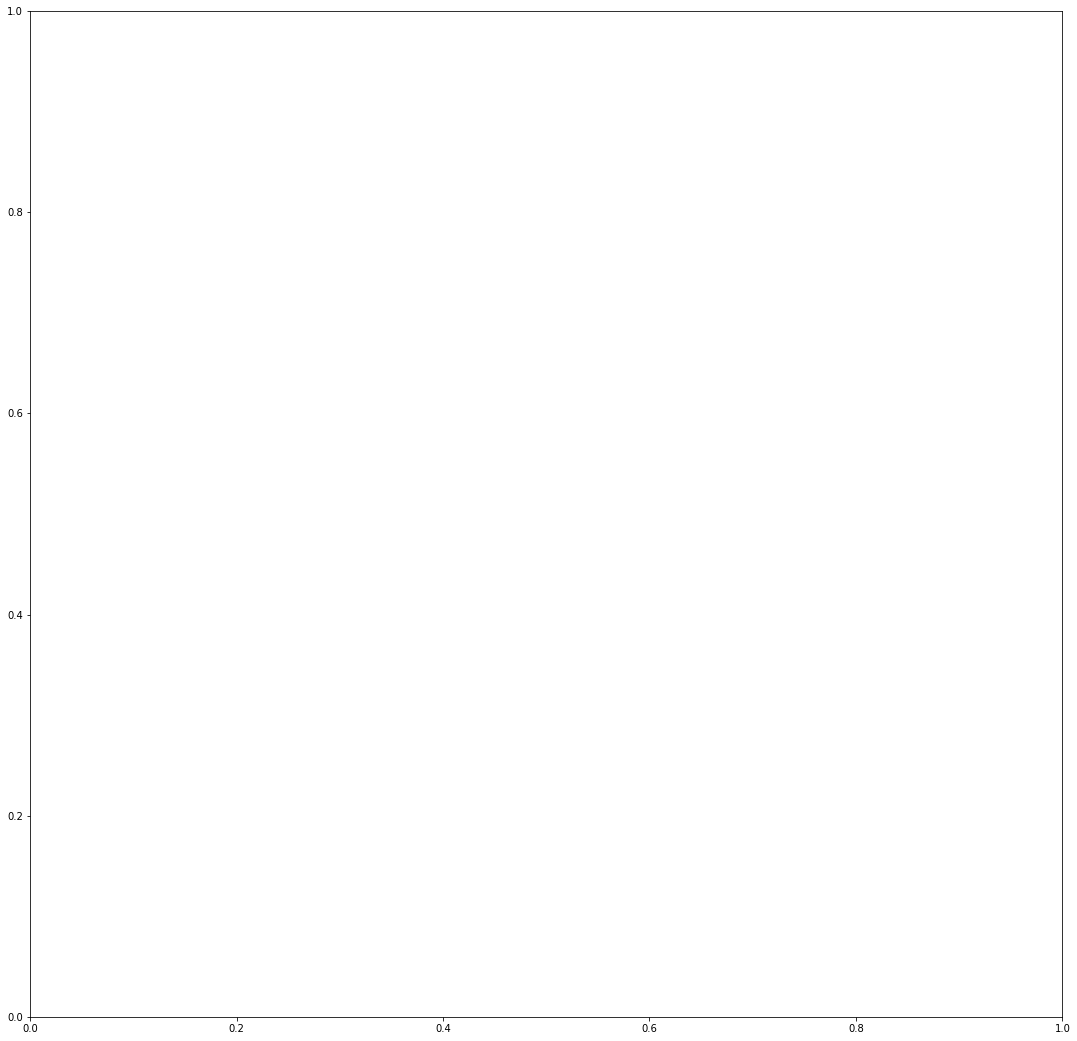

In [81]:
point = w_duration.iloc[ 3 , : ].to_frame().transpose()
print(point)
plot_point_transformer('Point transformer: All activities in all traces', w_duration, flavor='onetrace', size=1, duration_plot=1, allen_point=point)
#plot_point_transformer('Point transformer: All activities in all traces', snippet, flavor='all', size=1, allen_point=snippet[(snippet['case']==4)&(snippet['num_start']==75840)])